<a href="https://colab.research.google.com/github/rcpaffenroth/dac_raghu/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

import json

In [13]:
name = 'circle'
# Read the json info file
with open(f'../data/processed/info.json') as f:
    info = json.load(f)
# Read the start data
x_start = pd.read_parquet(f'../data/processed/{name}_start.parquet')
# Read the target data
x_target = pd.read_parquet(f'../data/processed/{name}_target.parquet')


# Dynamical system

In [14]:
x_size = x_start.shape[1]

# # A pytorch module that multiplies the output of two other modules, where the two modules are given as arguments to the constructor, and the fo
# # The forward method takes a single argument and returns a single tensor.
# class Multiply(nn.Module):
#     def __init__(self, module1, module2):
#         super().__init__()
#         self.module1 = module1
#         self.module2 = module2
#     def forward(self, x):
#         return self.module1(x) * self.module2(x)

# map = Multiply(nn.Linear(x_size, x_size), nn.Linear(x_size, x_size)) 

map = nn.Sequential(nn.Linear(x_size, 100), nn.ReLU(), nn.Linear(100, x_size))

In [15]:
# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Make two pytorch tensor datasets from the start and target data
x_start_tensor = df_to_tensor(x_start)
x_target_tensor = df_to_tensor(x_target)

# a dataloader which returns a batch of start and target data
class Data(torch.utils.data.Dataset):
    def __init__(self, x_start, x_target):
        self.x_start = x_start
        self.x_target = x_target
    def __len__(self):
        return len(self.x_start)
    def __getitem__(self, idx):
        return self.x_start[idx], self.x_target[idx]
    
train_data = Data(x_start_tensor, x_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

In [16]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(map.parameters(), lr=0.001)

In [17]:
max_epochs = 200
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()
        mapped = map(start)
        loss = criterion(mapped, target)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 9, Loss 0.33903267979621887
Epoch 10, Batch 9, Loss 0.006174288224428892
Epoch 20, Batch 9, Loss 0.004264685790985823
Epoch 30, Batch 9, Loss 0.004337234888225794
Epoch 40, Batch 9, Loss 0.00365114095620811
Epoch 50, Batch 9, Loss 0.0025384819600731134
Epoch 60, Batch 9, Loss 0.001773477648384869
Epoch 70, Batch 9, Loss 0.0015579377068206668
Epoch 80, Batch 9, Loss 0.0009383993456140161
Epoch 90, Batch 9, Loss 0.0006753096240572631
Epoch 100, Batch 9, Loss 0.0005447836010716856
Epoch 110, Batch 9, Loss 0.0003266273415647447
Epoch 120, Batch 9, Loss 0.00022017462470103055
Epoch 130, Batch 9, Loss 0.00018315650231670588
Epoch 140, Batch 9, Loss 0.00016956172476056963
Epoch 150, Batch 9, Loss 0.00010659885447239503
Epoch 160, Batch 9, Loss 7.898906187620014e-05
Epoch 170, Batch 9, Loss 7.889825064921752e-05
Epoch 180, Batch 9, Loss 8.973103831522167e-05
Epoch 190, Batch 9, Loss 6.845501775387675e-05


# Training data

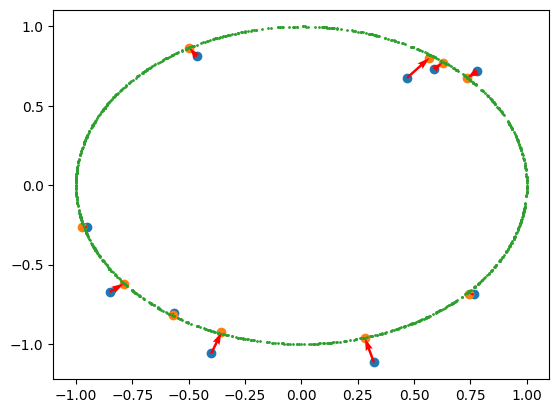

In [18]:
mapped_tensor = map(x_start_tensor).detach()
plot_points = 10

plt.figure()

plt.scatter(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1])
plt.scatter(mapped_tensor[:plot_points,0], mapped_tensor[:plot_points,1])
dx = mapped_tensor[:plot_points,0]-x_start_tensor[:plot_points,0]
dy = mapped_tensor[:plot_points,1]-x_start_tensor[:plot_points,1]
plt.quiver(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(x_target_tensor[:,0], x_target_tensor[:,1], s=1)
plt.show()

# Testing data

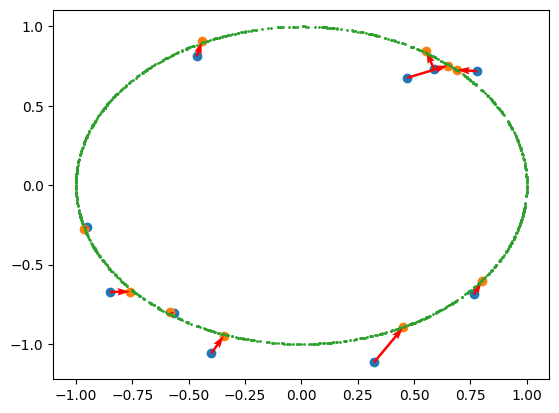

In [19]:
mapped_tensor = map(x_start_tensor+torch.rand_like(x_start_tensor)*0.2).detach()
plot_points = 10

plt.figure()

plt.scatter(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1])
plt.scatter(mapped_tensor[:plot_points,0], mapped_tensor[:plot_points,1])
dx = mapped_tensor[:plot_points,0]-x_start_tensor[:plot_points,0]
dy = mapped_tensor[:plot_points,1]-x_start_tensor[:plot_points,1]
plt.quiver(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(x_target_tensor[:,0], x_target_tensor[:,1], s=1)
plt.show()

# Iterated model

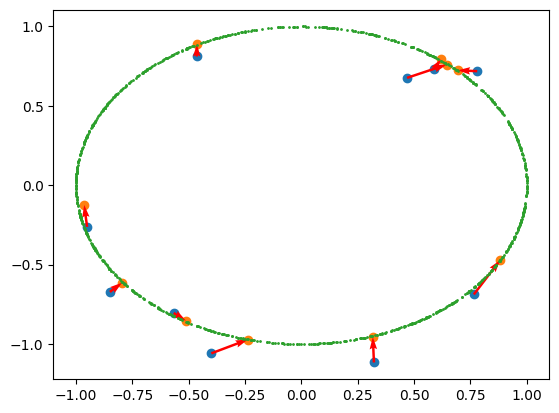

In [20]:
mapped_tensor = map(x_start_tensor+torch.rand_like(x_start_tensor)*0.2).detach()
plot_points = 10

plt.figure()

plt.scatter(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1])
plt.scatter(mapped_tensor[:plot_points,0], mapped_tensor[:plot_points,1])
dx = mapped_tensor[:plot_points,0]-x_start_tensor[:plot_points,0]
dy = mapped_tensor[:plot_points,1]-x_start_tensor[:plot_points,1]
plt.quiver(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(x_target_tensor[:,0], x_target_tensor[:,1], s=1)
plt.show()

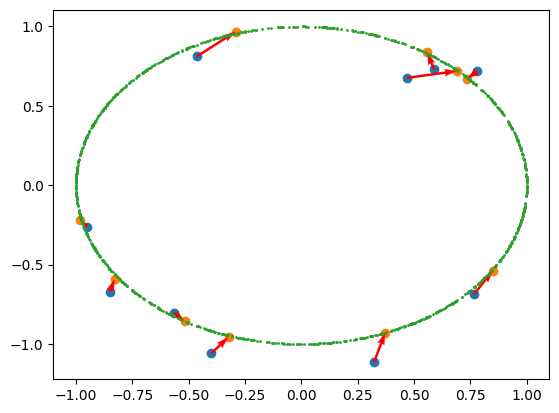

In [21]:
mapped_tensor = map(map(map(map(map(x_start_tensor+torch.rand_like(x_start_tensor)*0.2))))).detach()
plot_points = 10

plt.figure()

plt.scatter(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1])
plt.scatter(mapped_tensor[:plot_points,0], mapped_tensor[:plot_points,1])
dx = mapped_tensor[:plot_points,0]-x_start_tensor[:plot_points,0]
dy = mapped_tensor[:plot_points,1]-x_start_tensor[:plot_points,1]
plt.quiver(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

plt.scatter(x_target_tensor[:,0], x_target_tensor[:,1], s=1)
plt.show()

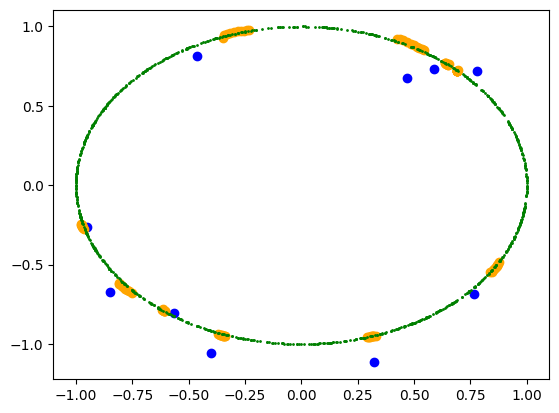

In [22]:
plot_points = 10

plt.figure()

plt.scatter(x_start_tensor[:plot_points,0], x_start_tensor[:plot_points,1], c='blue')

mapped_tensor = map(x_start_tensor+torch.rand_like(x_start_tensor)*0.2)

for i in range(10):
    plt.scatter(mapped_tensor[:plot_points,0].detach(), mapped_tensor[:plot_points,1].detach(), c='orange')
    mapped_tensor = map(mapped_tensor)

plt.scatter(x_target_tensor[:,0], x_target_tensor[:,1], s=1, c='green')
plt.show()